In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import PIL

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
data_dir = 'breast-cancer-data'

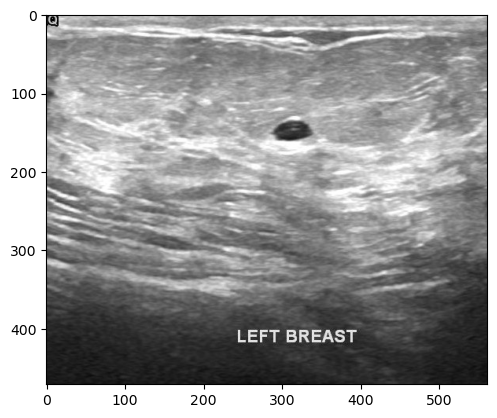

In [4]:
import matplotlib.image as mping
test_image = "breast-cancer-data/benign/benign (1).png"
img = mping.imread(test_image)
plt.imshow(img)

In [5]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180